# Utility Meter Reading Project

The aim of this project is to develop a system capable of accurately reading utility meter readings using OCR.  We will create a model to detect the region of interest in each image, focusing on the area where the meter reading is displayed. 

In [2]:
#Import Relevant Libraries
import re, cv2, os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps
from tqdm import tqdm
from sklearn.model_selection import train_test_split


In [6]:
%%writefile skip_kernel_extension.py
def skip(line, cell=None):
    '''Skips execution of the current line/cell if line evaluates to True.'''
    if eval(line):
        return

    get_ipython().ex(cell)

def load_ipython_extension(shell):
    '''Registers the skip magic when the extension loads.'''
    shell.register_magic_function(skip, 'line_cell')

def unload_ipython_extension(shell):
    '''Unregisters the skip magic when the extension unloads.'''
    del shell.magics_manager.magics['cell']['skip']

Overwriting skip_kernel_extension.py


In [7]:
%load_ext skip_kernel_extension

In [8]:
#Load data and paths
data = pd.read_csv('./WaterMeters/data.csv')
images_folder = "./WaterMeters/images"
masks_folder = "./WaterMeters/masks"
coll_folder = "./WaterMeters/collage"

## Exploratory Data Analyis

To start, let us see how many observations we will be working with and examine a few representative images of water meters.

In [9]:
#Obtain a count of images, masks, and observations.
print(f'Total number of images: {len(os.listdir(images_folder))}')
print(f'Total number of image masks: {len(os.listdir(masks_folder))}')
print(f'Length of dataset: {len(data)}')

Total number of images: 1244
Total number of image masks: 1244
Length of dataset: 1244


From the above output, we can see that there are 1244 images in this dataset, which corresponds to the number of masks and observations.

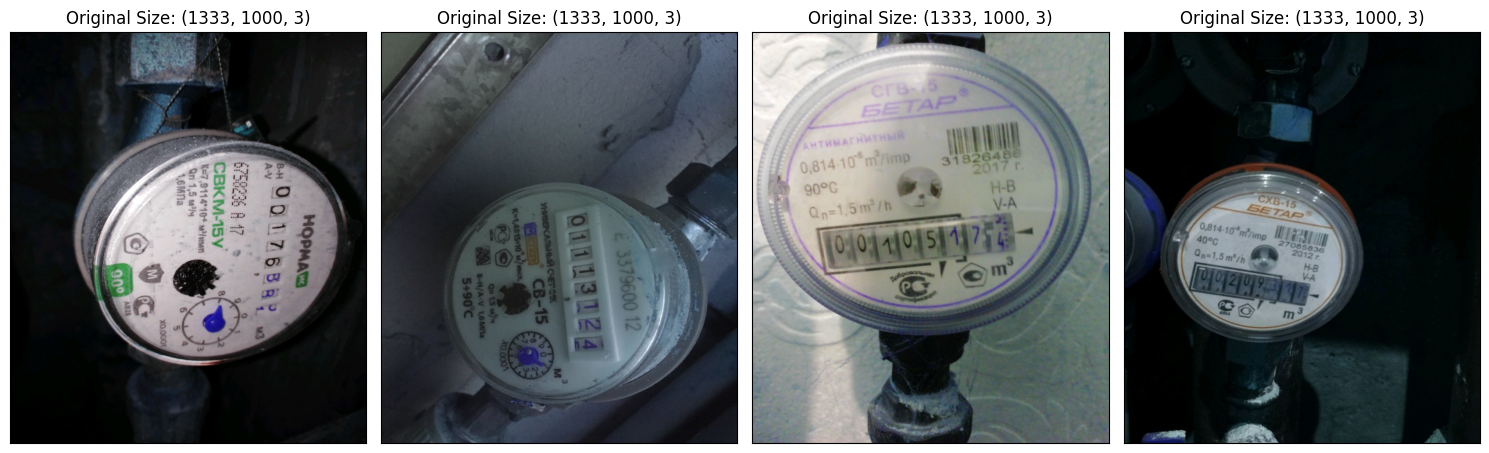

In [10]:
#Create figure and empty list for axes
axes=[]
fig=plt.figure(figsize=(15, 15))

#Show first 4 images in dataset with corresponding shape.
for a in range(4):
    #Obtain file name and create path.
    file = os.listdir("./WaterMeters/images/")[a]
    image_path = os.path.join(images_folder, file) 

    #Read the file image and resize it for show.
    img = cv2.imread(image_path)
    resized_image = cv2.resize(img, (1300, 1500), interpolation = cv2.INTER_AREA)
    
    #Print the resized image and dislpay the shape.
    axes.append(fig.add_subplot(1, 4, a+1) )
    subplot_title=(f"Original Size: {img.shape}")
    axes[-1].set_title(subplot_title)  
    plt.imshow(resized_image)

#Remove ticks from each image.
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#Plot the image.
fig.tight_layout()    
plt.show()

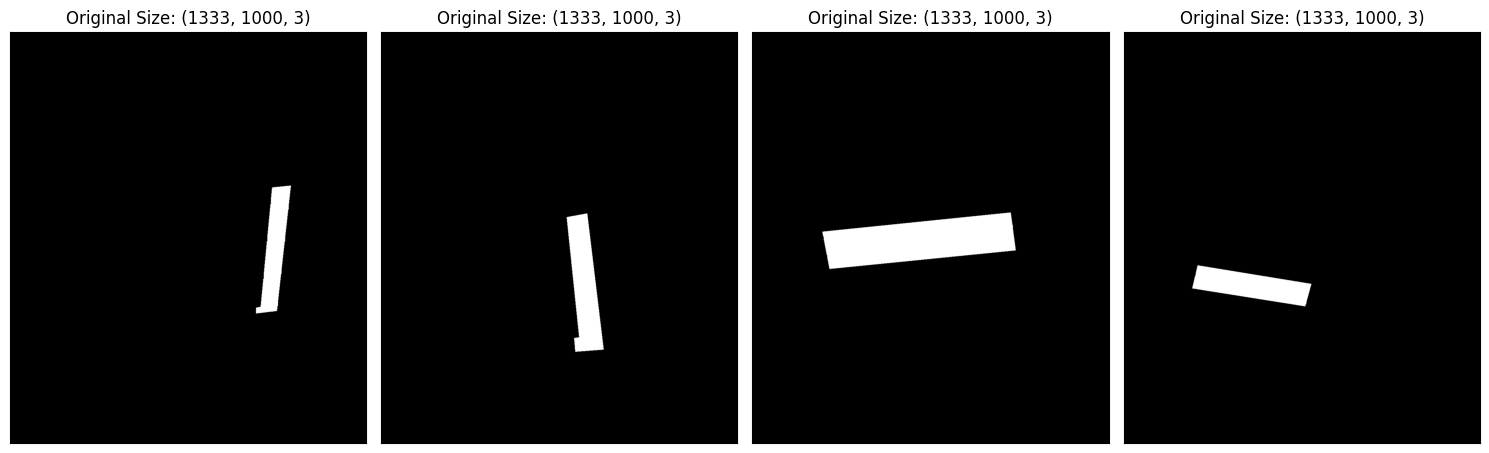

In [11]:
#Create figure and empty list for axes
axes=[]
fig=plt.figure(figsize=(15, 15))

#Show first 4 images in dataset with corresponding shape.
for a in range(4):
    #Obtain file name and create path.
    file = os.listdir("./WaterMeters/masks/")[a]
    image_path = os.path.join(masks_folder, file) 
    
    #Read the file image and resize it for show.
    img = cv2.imread(image_path)
    resized_image = cv2.resize(img, (1300, 1500), interpolation = cv2.INTER_AREA)
    
    #Print the resized image and dislpay the shape.
    axes.append(fig.add_subplot(1, 4, a+1) )
    subplot_title=(f"Original Size: {img.shape}")
    axes[-1].set_title(subplot_title)  
    plt.imshow(resized_image)

#Remove ticks from each image.
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#Plot the image.
fig.tight_layout()    
plt.show()

In [12]:
#Examine the head of the 'data' DataFrame
pd.set_option('display.max_colwidth', 70)
display(data.head())

photo_name    value  \
0   id_53_value_595_825.jpg  595.825   
1   id_553_value_65_475.jpg   65.475   
2    id_407_value_21_86.jpg   21.860   
3  id_252_value_313_322.jpg  313.322   
4  id_851_value_305_162.jpg  305.162   

                                                                location  
0  {'type': 'polygon', 'data': [{'x': 0.30788, 'y': 0.30207}, {'x': 0...  
1  {'type': 'polygon', 'data': [{'x': 0.26133, 'y': 0.24071}, {'x': 0...  
2  {'type': 'polygon', 'data': [{'x': 0.27545, 'y': 0.19134}, {'x': 0...  
3  {'type': 'polygon', 'data': [{'x': 0.21967, 'y': 0.50845}, {'x': 0...  
4  {'type': 'polygon', 'data': [{'x': 0.06983, 'y': 0.43491}, {'x': 0...

In [13]:
#Create function to extract polygon locations from 'location' string.
def location_vals(obvs, x_or_y):
    '''
    Function uses regular expressions to parse the "location" string for each observation.
    Inputs are "obvs" and "x_or_y".
    
    obvs: This simply serves as the string being passed into the function.
    x_or_y: If "x" is entered, then the function extracts all "x" location values. If anything else, then it extracts "y" location values.
    '''
    if x_or_y == 'x':
        x = re.findall(r"\'x\': ([0-9.]*),", obvs)
        return x
    else:
        y = re.findall(r"\'y\': ([0-9.]*)}", obvs)
        return y

In [14]:
#Create new column with x and y location values.
data['x_loc_perc'] = data['location'].apply(lambda obvs: location_vals(obvs, 'x'))
data['y_loc_perc'] = data['location'].apply(lambda obvs: location_vals(obvs, 'y'))
display(data.head())

photo_name    value  \
0   id_53_value_595_825.jpg  595.825   
1   id_553_value_65_475.jpg   65.475   
2    id_407_value_21_86.jpg   21.860   
3  id_252_value_313_322.jpg  313.322   
4  id_851_value_305_162.jpg  305.162   

                                                                location  \
0  {'type': 'polygon', 'data': [{'x': 0.30788, 'y': 0.30207}, {'x': 0...   
1  {'type': 'polygon', 'data': [{'x': 0.26133, 'y': 0.24071}, {'x': 0...   
2  {'type': 'polygon', 'data': [{'x': 0.27545, 'y': 0.19134}, {'x': 0...   
3  {'type': 'polygon', 'data': [{'x': 0.21967, 'y': 0.50845}, {'x': 0...   
4  {'type': 'polygon', 'data': [{'x': 0.06983, 'y': 0.43491}, {'x': 0...   

                                                              x_loc_perc  \
0  [0.30788, 0.30676, 0.53501, 0.53445, 0.56529, 0.56697, 0.53501, 0....   
1                 [0.26133, 0.31405, 0.31741, 0.30676, 0.33985, 0.29386]   
2                                   [0.27545, 0.37483, 0.38935, 0.28185]   
3                                   [0.21967, 0.70811, 0.70008, 0.21699]   
4  [0.06983, 0.34763, 0.34663, 0.36622, 0.37125, 0.34964, 0.34814, 0....   

                                                              y_loc_perc  
0  [0.30207, 0.32731, 0.33068, 0.33699, 0.33741, 0.29786, 0.29786, 0....  
1                 [0.24071, 0.23473, 0.26688, 0.26763, 0.60851, 0.61449]  
2                                   [0.19134, 0.18282, 0.76071, 0.76613]  
3                                   [0.50845, 0.53256, 0.61295, 0.58883]  
4  [0.43491, 0.42285, 0.41795, 0.41607, 0.4628, 0.46506, 0.45941, 0.4...

In [15]:
#Creat function to return image size.
def image_size(img_name):
    '''
    The image name from each observation serves as the input.
    The image is then read using cv2, and its shape is returned.
    '''
    image_path = os.path.join(images_folder, img_name)
    img = cv2.imread(image_path)
    return img.shape

#Apply function to each row of DataFrame.
data['shape'] = data['photo_name'].apply(image_size)
display(data.head())

photo_name    value  \
0   id_53_value_595_825.jpg  595.825   
1   id_553_value_65_475.jpg   65.475   
2    id_407_value_21_86.jpg   21.860   
3  id_252_value_313_322.jpg  313.322   
4  id_851_value_305_162.jpg  305.162   

                                                                location  \
0  {'type': 'polygon', 'data': [{'x': 0.30788, 'y': 0.30207}, {'x': 0...   
1  {'type': 'polygon', 'data': [{'x': 0.26133, 'y': 0.24071}, {'x': 0...   
2  {'type': 'polygon', 'data': [{'x': 0.27545, 'y': 0.19134}, {'x': 0...   
3  {'type': 'polygon', 'data': [{'x': 0.21967, 'y': 0.50845}, {'x': 0...   
4  {'type': 'polygon', 'data': [{'x': 0.06983, 'y': 0.43491}, {'x': 0...   

                                                              x_loc_perc  \
0  [0.30788, 0.30676, 0.53501, 0.53445, 0.56529, 0.56697, 0.53501, 0....   
1                 [0.26133, 0.31405, 0.31741, 0.30676, 0.33985, 0.29386]   
2                                   [0.27545, 0.37483, 0.38935, 0.28185]   
3                                   [0.21967, 0.70811, 0.70008, 0.21699]   
4  [0.06983, 0.34763, 0.34663, 0.36622, 0.37125, 0.34964, 0.34814, 0....   

                                                              y_loc_perc  \
0  [0.30207, 0.32731, 0.33068, 0.33699, 0.33741, 0.29786, 0.29786, 0....   
1                 [0.24071, 0.23473, 0.26688, 0.26763, 0.60851, 0.61449]   
2                                   [0.19134, 0.18282, 0.76071, 0.76613]   
3                                   [0.50845, 0.53256, 0.61295, 0.58883]   
4  [0.43491, 0.42285, 0.41795, 0.41607, 0.4628, 0.46506, 0.45941, 0.4...   

             shape  
0  (1333, 1000, 3)  
1  (1000, 1333, 3)  
2  (1000, 1333, 3)  
3  (1333, 1000, 3)  
4  (1333, 1000, 3)

As we can see, each observation in the DataFrame now contains the associated image's shape, along with the locations of each point of the image's ROI. To get a better feeling for our data, let us examine the statistics for the dimensions of images contained in our dataset.

In [16]:
#Save height and weight data as separate features.
data['height'] = data['shape'].apply(lambda x: x[0])
data['width'] = data['shape'].apply(lambda x: x[1])

#Display stats for height and width of images.
data[['height', 'width']].describe()

height        width
count  1244.000000  1244.000000
mean   1320.112540  1060.707395
std     201.842639   159.417396
min     480.000000   864.000000
25%    1333.000000  1000.000000
50%    1333.000000  1000.000000
75%    1333.000000  1000.000000
max    2168.000000  2058.000000

Finally, before moving to the next step, it's important to ensure that the images in all folders have the same relative location. This is because we will be iterating through the images in at least two folders when building a mask segmentation model. If an image segmentation model is trained with mismatched imgaes and masks, then we the algorithm will perform very poorly.

In [17]:
#Make sure that similar all files in each folder have the same location.
for i, j, k in zip(os.listdir(masks_folder), \
                   os.listdir(images_folder), \
                   os.listdir(coll_folder)):
    if (i == j) & (j == k):
        pass
    else:
        print(f'File {i} in one folder does not match name in others.')

# Build Segmentation Model

In this section of the project we will attempt to build an image segmentation model. Based on our research, it appears that UNet models allow for training using images and their associated masks. Since we have all the information necessary to train such a model, we will attempt to use UNet for the segmentation portion of the project.

In [18]:
#Create arrays 
y = np.zeros((1244, 224, 224), dtype='float32')
X = np.zeros((1244, 224, 224, 3), dtype='float32')

for n, image, mask in tqdm(zip(range(1244), os.listdir(images_folder), os.listdir(masks_folder))):
    dir_img = os.path.join(images_folder, image)
    dir_mask = os.path.join(masks_folder, mask)
    
    #Open image, resize it.
    img = cv2.imread(dir_img)
    img = cv2.resize(img, (224, 224))
    #img = ImageOps.exif_transpose(img)
    X[n] = img 
    
    #Open mask image, resize and normalize it.
    msk = cv2.imread(dir_mask)
    msk = cv2.resize(msk, (224, 224))
    
    #Normalize mask values.
    msk = 1.0 * (msk[:, :, 0] > .1)
    
    #Save mask array to y array.
    y[n] = msk   

1244it [00:32, 38.73it/s]


In [19]:
#Create function to plot images used with segmentation. 
def plot_seg_imgs(array_or_collage, name):
    '''
    This function can be called to print 4 images used with the segmentation model.
    array_or_collage - Accepts any values for arrays, from training arrays to predicted outputs.
        Also accepts 'collage': If this is input, then 4 images from the collages folder will be printed.
    name - What name would you like printed with the number of each image plotted.
    '''
    axes=[]
    fig=plt.figure(figsize=(15, 15))

    for a in range(4):
        
        #Print the resized image and dislpay the shape.
        axes.append(fig.add_subplot(1, 4, a+1))
        subplot_title=(f"{name} Image #{a} Resized")
        axes[-1].set_title(subplot_title)  
        
        if str(array_or_collage) == 'collage':
            img = cv2.imread(os.path.join(coll_folder, os.listdir(coll_folder)[a]))
            img = cv2.resize(img, (224, 224))
            plt.imshow(img)
        else:
            plt.imshow(array_or_collage[a].astype('uint8'))
            
    #Remove ticks from each image.
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    #Plot the image.
    fig.tight_layout()    
    plt.show()

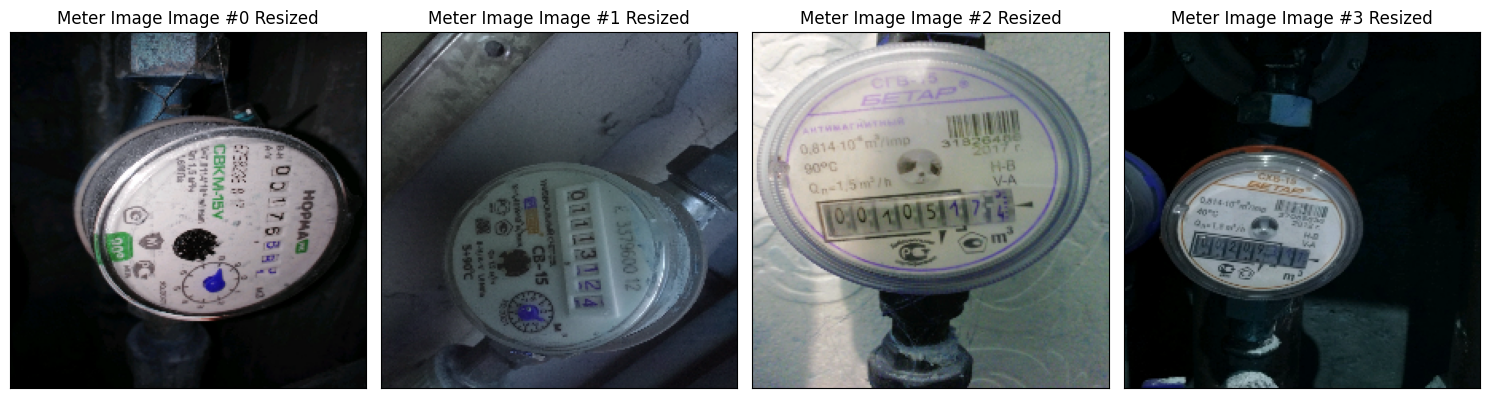

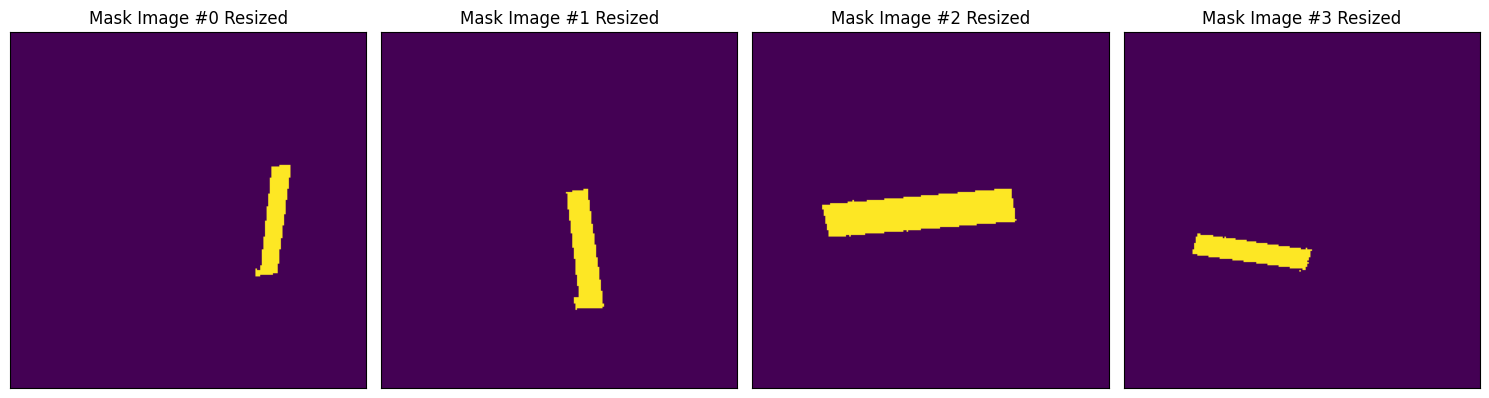

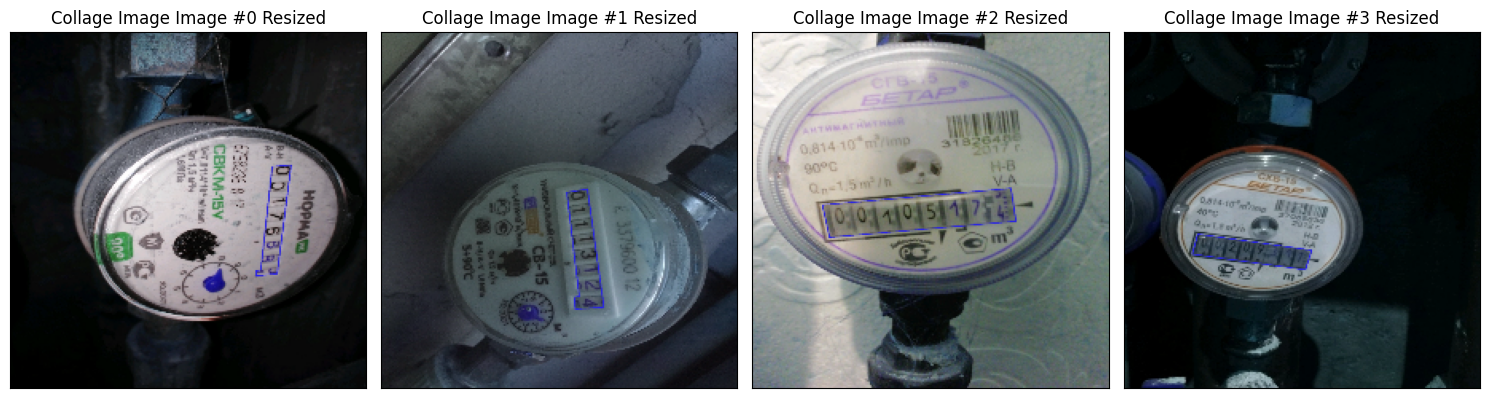

In [20]:
#Print first 4 resized meter, resized mask, and collage images.
plot_seg_imgs(X,'Meter Image')
plot_seg_imgs(y, 'Mask')
plot_seg_imgs('collage', 'Collage Image')

From the above images, we can see that the resized masks are appropriately positioned with regard to the location of the meter reading region for each meter pictured. We can see, however, that unlike the original masks, these are quite pixelated. This is due to our downsizing the mask images to a small fraction of their original size. This should not be problematic for our later UNet model; however, if it does prove problematic, we will adjust the mask sizes accordingly.

In [21]:
#Split data into train and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Segmentation Mask

In [22]:
%%capture

#Download segmentation model from github.
!pip install git+https://github.com/qubvel/segmentation_models
    
import segmentation_models as sm

  Cloning https://github.com/qubvel/segmentation_models to c:\users\bhard\appdata\local\temp\pip-req-build-2lyygul3
  Resolved https://github.com/qubvel/segmentation_models to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models 'C:\Users\bhard\AppData\Local\Temp\pip-req-build-2lyygul3'
  Running command git submodule update --init --recursive -q


In [23]:
import segmentation_models as sm
            
sm.set_framework('tf.keras')
sm.framework()

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

#Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

# define model
model1 = sm.Unet(BACKBONE, encoder_weights='imagenet')
model1.compile(
    opt,
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

try: 
    #fname = os.path.sep.join([os.getcwd(), "weights-file.hdf5"])
    fname = './input/weights/weights-file.hdf5'
    print('Weights file loaded.')
except:
    pass

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='new_weights_output.hdf5',
    save_weights_only=False,
    monitor='val_iou_score',
    mode='max',
    save_best_only=True,
    verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)


model1.load_weights(fname)
print("Weight has been loaded success fully")


# fit model
model1.fit(
   x=X_train,
   y=y_train,
   batch_size=16,
   epochs=20, #Only 10, since we've pretrained the model.
   validation_data=(X_test, y_test),
   callbacks=[model_checkpoint_callback, early_stopping]
)

model1.save('final_segmentation_model')

# The model weights (that are considered the best) are loaded into the model.
#model.load_weights(fname)

Weights file loaded.
Weight has been loaded success fully
Epoch 1/20
63/63 [==============================] - ETA: 0s - loss: 0.0356 - iou_score: 0.9683
Epoch 1: val_iou_score improved from -inf to 0.97470, saving model to new_weights_output.hdf5
63/63 [==============================] - 217s 3s/step - loss: 0.0356 - iou_score: 0.9683 - val_loss: 0.0283 - val_iou_score: 0.9747
Epoch 2/20
63/63 [==============================] - ETA: 0s - loss: 0.0341 - iou_score: 0.9692
Epoch 2: val_iou_score did not improve from 0.97470
63/63 [==============================] - 195s 3s/step - loss: 0.0341 - iou_score: 0.9692 - val_loss: 0.0299 - val_iou_score: 0.9732
Epoch 3/20
63/63 [==============================] - ETA: 0s - loss: 0.0290 - iou_score: 0.9734
Epoch 3: val_iou_score did not improve from 0.97470
63/63 [==============================] - 208s 3s/step - loss: 0.0290 - iou_score: 0.9734 - val_loss: 0.0294 - val_iou_score: 0.9737
Epoch 4/20
63/63 [==============================] - ETA: 0s - l

INFO:tensorflow:Assets written to: final_segmentation_model\assets


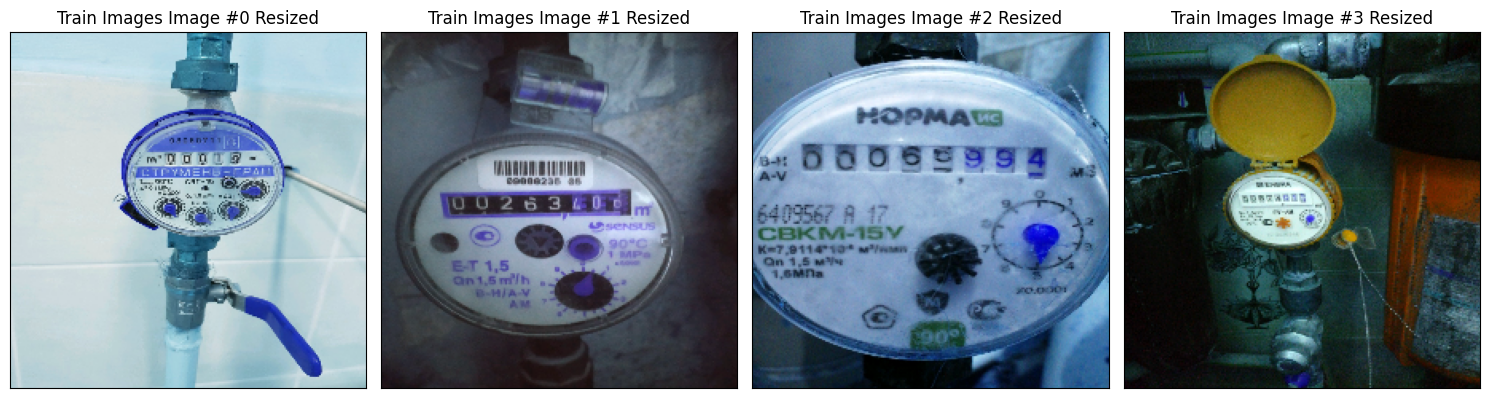

32/32 [==============================] - 52s 2s/step


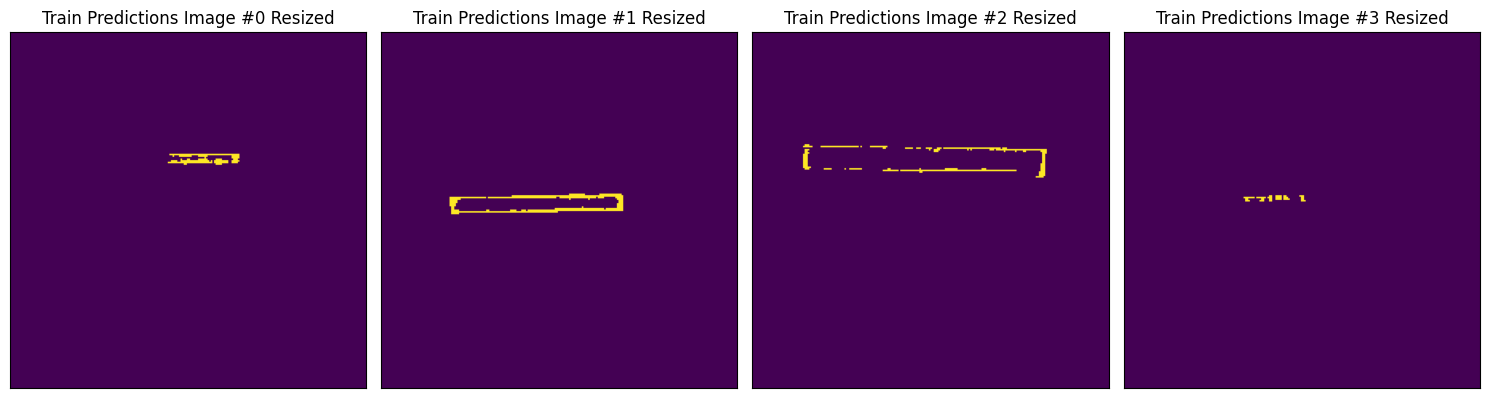

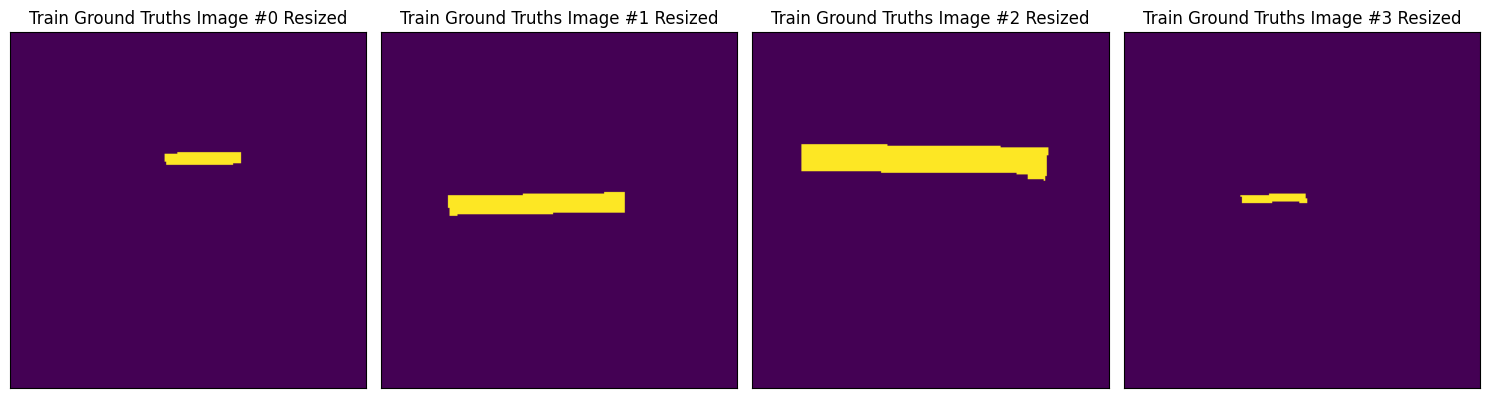

In [24]:
# Examine predictions for training images.
plot_seg_imgs(X_train, 'Train Images')
plot_seg_imgs(model1.predict(X_train), 'Train Predictions')
plot_seg_imgs(y_train, 'Train Ground Truths')

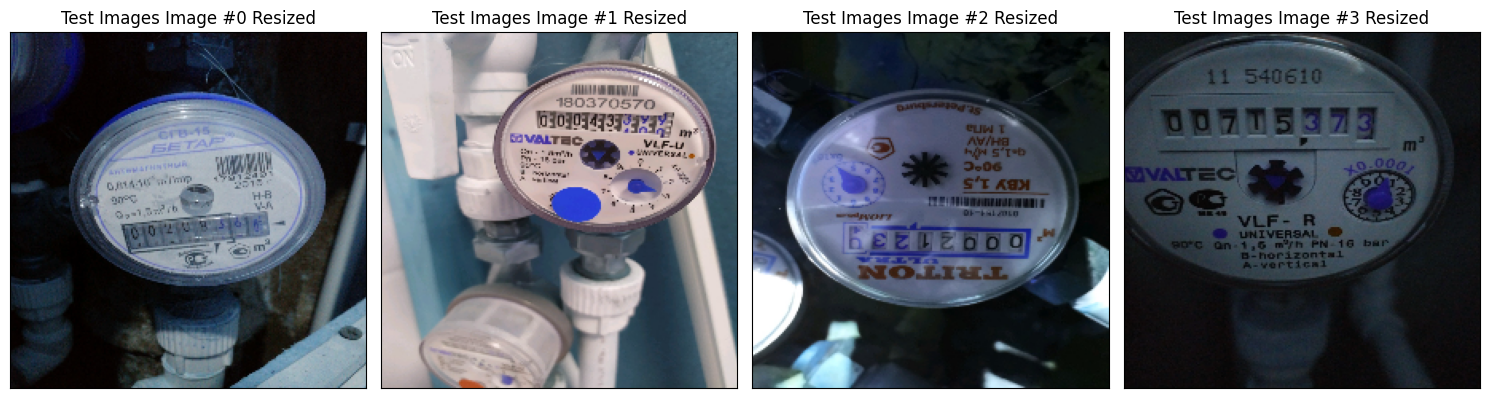

8/8 [==============================] - 10s 1s/step


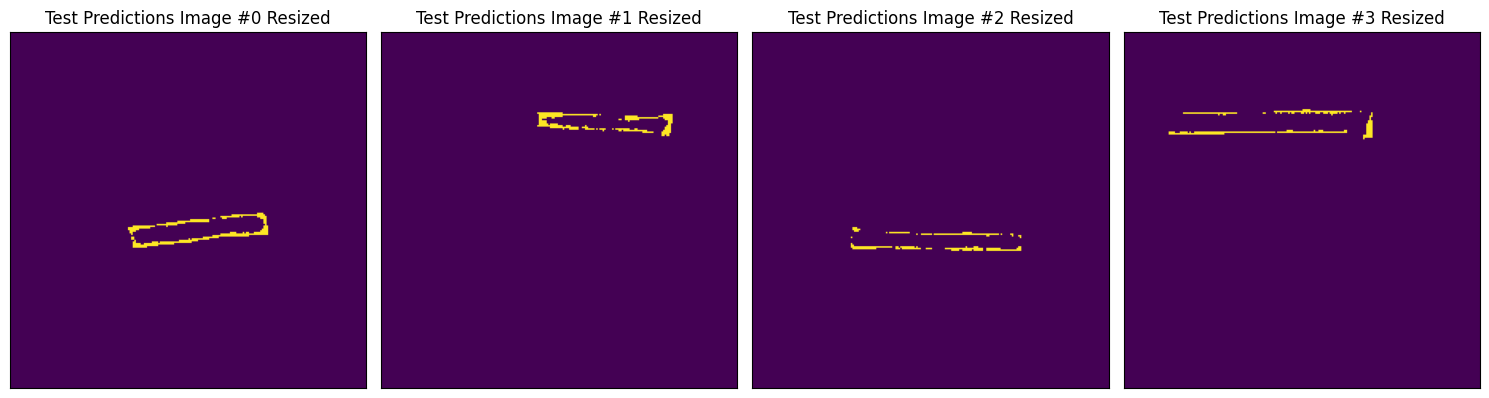

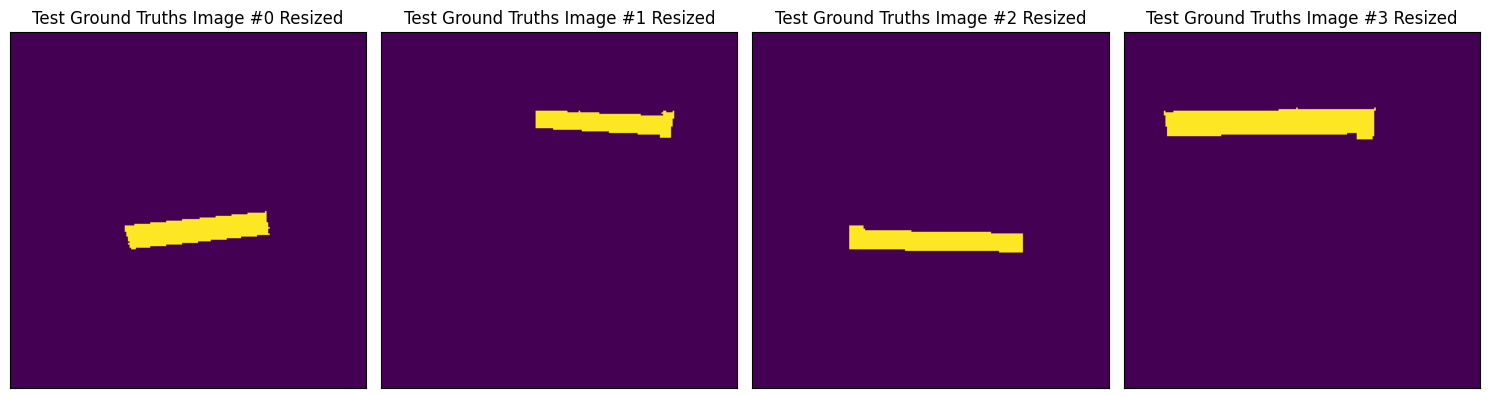

In [23]:
#Examine predictions for testing images.
plot_seg_imgs(X_test, 'Test Images')
plot_seg_imgs(model1.predict(X_test), 'Test Predictions')
plot_seg_imgs(y_test, 'Test Ground Truths')

### Crop Images

In [65]:
#Create function to crop images.
def crop(img, bg, mask) -> np.array:
    '''
    Function takes image, background, and mask, and crops the image.
    The cropped image should correspond only with the positive portion of the mask.
    '''
    fg = cv2.bitwise_or(img, img, mask=mask) 
    fg_back_inv = cv2.bitwise_or(bg, bg, mask=cv2.bitwise_not(mask))
    New_image = cv2.bitwise_or(fg, fg_back_inv)
    return New_image

In [41]:
#%%skip True

#Crop training images using supplied masks.
if os.path.exists('./cropped_for_ocr') == False:
    os.mkdir('cropped_for_ocr')
else:
    pass

ocr_path = './cropped_for_ocr'

for n, image, mask in tqdm(zip(range(len(os.listdir(images_folder))), os.listdir(images_folder), os.listdir(masks_folder))):
    dir_img = os.path.join(images_folder, image)
    dir_mask = os.path.join(masks_folder, mask)
    
    #Read images and masks.
    img = cv2.imread(dir_img).astype('uint8')
    mask = cv2.imread(dir_mask).astype('uint8')
    
    #Get dimensions of image.
    h, w, _ = img.shape
    
    #Ensure mask is binary, and create black background in shape of image.
    mask = cv2.resize(cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY), (w, h)) # Resize image
    bg = np.zeros_like(img, 'uint8') # Black background

    #Crop image based on mask and make it RBG.
    New_image = crop(img,bg,mask)
    New_image = cv2.cvtColor(New_image, cv2.COLOR_BGR2RGB)

    #Extract portion of image where meter reading is.
    #Use min and max x and y coordinates to obtain final image.
    where = np.array(np.where(New_image))
    x1, y1, z1 = np.amin(where, axis=1)
    x2, y2, z2 = np.amax(where, axis=1)
    sub_image = New_image.astype('uint8')[x1:x2, y1:y2]

    #Write image to file
    cv2.imwrite(os.path.join(ocr_path , image), sub_image)

1244it [01:26, 14.36it/s]


In [2]:
#Chose random image.
random_img = './WaterMeters/images/id_1022_value_95_735.jpg'

#Specify files for model weights.
# segmentation_model_file = './input/water-meter-ocr-images/final_segmentation_model'
segmentation_model_file = './final_segmentation_model'
faster_rcnn_path = './input/water-meter-ocr-images/output/model_final.pth' #<-- for cfg.MODEL.WEIGHTS

In [3]:
#Function to resize image.
def prod_resize_input(img_link):
    '''
    Function takes an image and resizes it.
    '''
    img = cv2.imread(img_link)
    img = cv2.resize(img, (224, 224))
    return img.astype('uint8')

#Create function to crop images.
def crop_for_seg(img, bg, mask):
    '''
    Function extracts an image where it overlaps with its binary mask.
    img - Image to be cropped.
    bg - The background on which to cast the image.
    mask - The binary mask generated from the segmentation model.
    '''
    #mask = mask.astype('uint8')
    fg = cv2.bitwise_or(img, img, mask=mask) 
    fg_back_inv = cv2.bitwise_or(bg, bg, mask=cv2.bitwise_not(mask))
    New_image = cv2.bitwise_or(fg, fg_back_inv)
    return New_image

def extract_meter(image_to_be_cropped):
    '''
    Function further extracts image such that the meter reading takes up the majority of the image.
    The function finds the edges of the ROI and extracts the portion of the image that contains the entire ROI.
    '''
    where = np.array(np.where(image_to_be_cropped))
    if where.size == 0:
        return image_to_be_cropped
    x1, y1, z1 = np.amin(where, axis=1)
    x2, y2, z2 = np.amax(where, axis=1)
    sub_image = image_to_be_cropped.astype('uint8')[x1:x2, y1:y2]
    return sub_image

def rotate(image: np.ndarray, angle: float, background: Union[int, Tuple[int, int, int]]) -> np.ndarray:
    '''
    This function attempts to rotate meter reading images to make them horizontal.
    Its arguments are as follows:
    
    image - The image to be deskewed (in numpy array format).
    angle - The current angle of the image, found with the determine_skew function of the deskew library.
    background - The pixel values of the boarder, either int (default 0) or a tuple.
    
    The function returns a numpy array.
    '''
    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)
    
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

def resize_aspect_fit(img, final_size: int):
    '''
    Function resizes the image to specified size.
    
    path - The path to the directory with images.
    final_size - The size you want the final images to be. Should be in int (will be used for w and h).
    write_to - The file you wish to write the images to. 
    save - Whether to save the files (True) or return them.
    '''   
    im_pil = Image.fromarray(img)
    size = im_pil.size
    ratio = float(final_size) / max(size)
    new_image_size = tuple([int(x*ratio) for x in size])
    im_pil = im_pil.resize(new_image_size, Image.ANTIALIAS)
    new_im = Image.new("RGB", (final_size, final_size))
    new_im.paste(im_pil, ((final_size-new_image_size[0])//2, (final_size-new_image_size[1])//2))
    new_im = np.asarray(new_im)
    return np.array(new_im)

def prep_for_ocr(img):
    img = resize_aspect_fit(img, 224)
    output_name = 'test_img_for_ocr.jpg'
    cv2.imwrite(output_name, img)
    return output_name

def expand_mask_surrounding(mask):
    global new_mask  # Declare that we're using the global variable
    new_mask = mask.copy()  # Make a copy of the mask and assign it to the global variable
    positions = np.column_stack(np.where(mask == 1))
    if positions.size == 0:
        return new_mask
    min_x, min_y = positions.min(axis=0)
    max_x, max_y = positions.max(axis=0)
    new_mask[min_x:max_x + 1, min_y:max_y + 1] = 1
    return new_mask

#Segment input image.
def segment_input_img(img):
        
    #Resize image.
    img_small = prod_resize_input(img)
    
    #Open image and get dimensions.
    input_img = cv2.imread(img, cv2.IMREAD_UNCHANGED)
    input_w = int(input_img.shape[1])
    input_h = int(input_img.shape[0])
    dim = (input_w, input_h)
    
    # #Load model, preprocess input, and obtain prediction.
    # BACKBONE = 'resnet34'
    # preprocess_input = sm.get_preprocessing(BACKBONE)
    # img_small = preprocess_input(img_small)
    img_small = img_small.reshape(-1, 224, 224, 3).astype('uint8')
    model = tf.keras.models.load_model(segmentation_model_file, custom_objects={'binary_crossentropy_plus_jaccard_loss': sm.losses.bce_jaccard_loss, 'iou_score' : sm.metrics.iou_score})
    mask = model.predict(img_small)
    
    #Change type to uint8 and fill in holes.
    mask = mask.astype('uint8')
    mask = scipy.ndimage.morphology.binary_fill_holes(mask[0, :, :, 0]).astype('uint8')
    
    #Resize mask to equal input image size.
    mask = cv2.resize(mask, dsize=dim, interpolation=cv2.INTER_AREA)
   
    # Taking a matrix of size 5 as the kernel
    kernel = np.ones((10,10), np.uint8)
    
    mask = cv2.dilate(mask, kernel, iterations=3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15)))
    
    #Create background array.
    bg = np.zeros_like(input_img, 'uint8')
    expand_mask = expand_mask_surrounding(mask)
 
    #Get new cropped image and make RGB.
    New_image = crop_for_seg(input_img, bg, expand_mask)
    New_image = cv2.cvtColor(New_image, cv2.COLOR_BGR2RGB)
    plt.imshow(New_image)
    #Extract meter portion.
    extracted = extract_meter(New_image)
    
    grayscale = cv2.cvtColor(extracted, cv2.COLOR_BGR2GRAY)
    angle = determine_skew(grayscale)
    
    if angle == None:
        angle = 1
    
    rotated = rotate(extracted, angle, (0, 0, 0))
    
    return rotated

In [31]:
def plot_corp_imgs(image_list, name):
    '''
    This function can be called to print 4 images used with the segmentation model.
    array_or_collage - Accepts any values for arrays, from training arrays to predicted outputs.
        Also accepts 'collage': If this is input, then 4 images from the collages folder will be printed.
    name - What name would you like printed with the number of each image plotted.
    '''
    axes=[]
    fig=plt.figure(figsize=(45, 45))
    
    for a in range(10):
        
        #Print the resized image and dislpay the shape.
        axes.append(fig.add_subplot(1, 10, a+1))
        subplot_title=(f"{name} Image #{a} Resized")
        axes[-1].set_title(subplot_title)  
        
        # if str(array_or_collage) == 'collage':
        #     img = cv2.imread(os.path.join(coll_folder, os.listdir(coll_folder)[a]))
        #     img = cv2.resize(img, (224, 224))
        #     plt.imshow(img)
        # else:
        #     plt.imshow(image_list[a].astype('uint8'))
        plt.imshow(segment_input_img(image_list[a]))
            
    #Remove ticks from each image.
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    #Plot the image.
    fig.tight_layout()    
    plt.show()

1/1 [==============================] - 1s 819ms/step


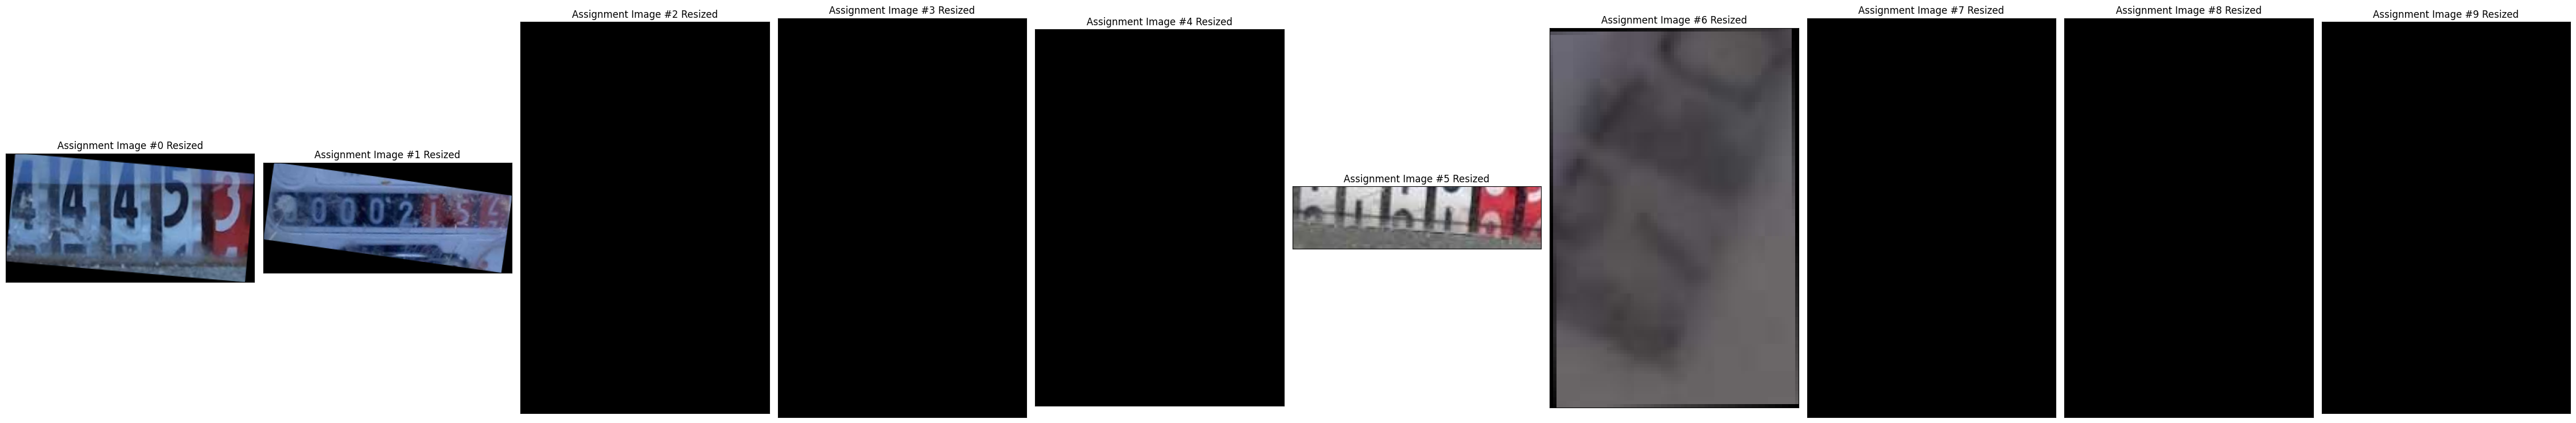

In [32]:
from glob import glob
img_fns = glob(r'D:\Anuj\Study\project\utility meeter reading\assignment_image\*')
plot_corp_imgs(img_fns, "Assignment")

1/1 [==============================] - 1s 795ms/step


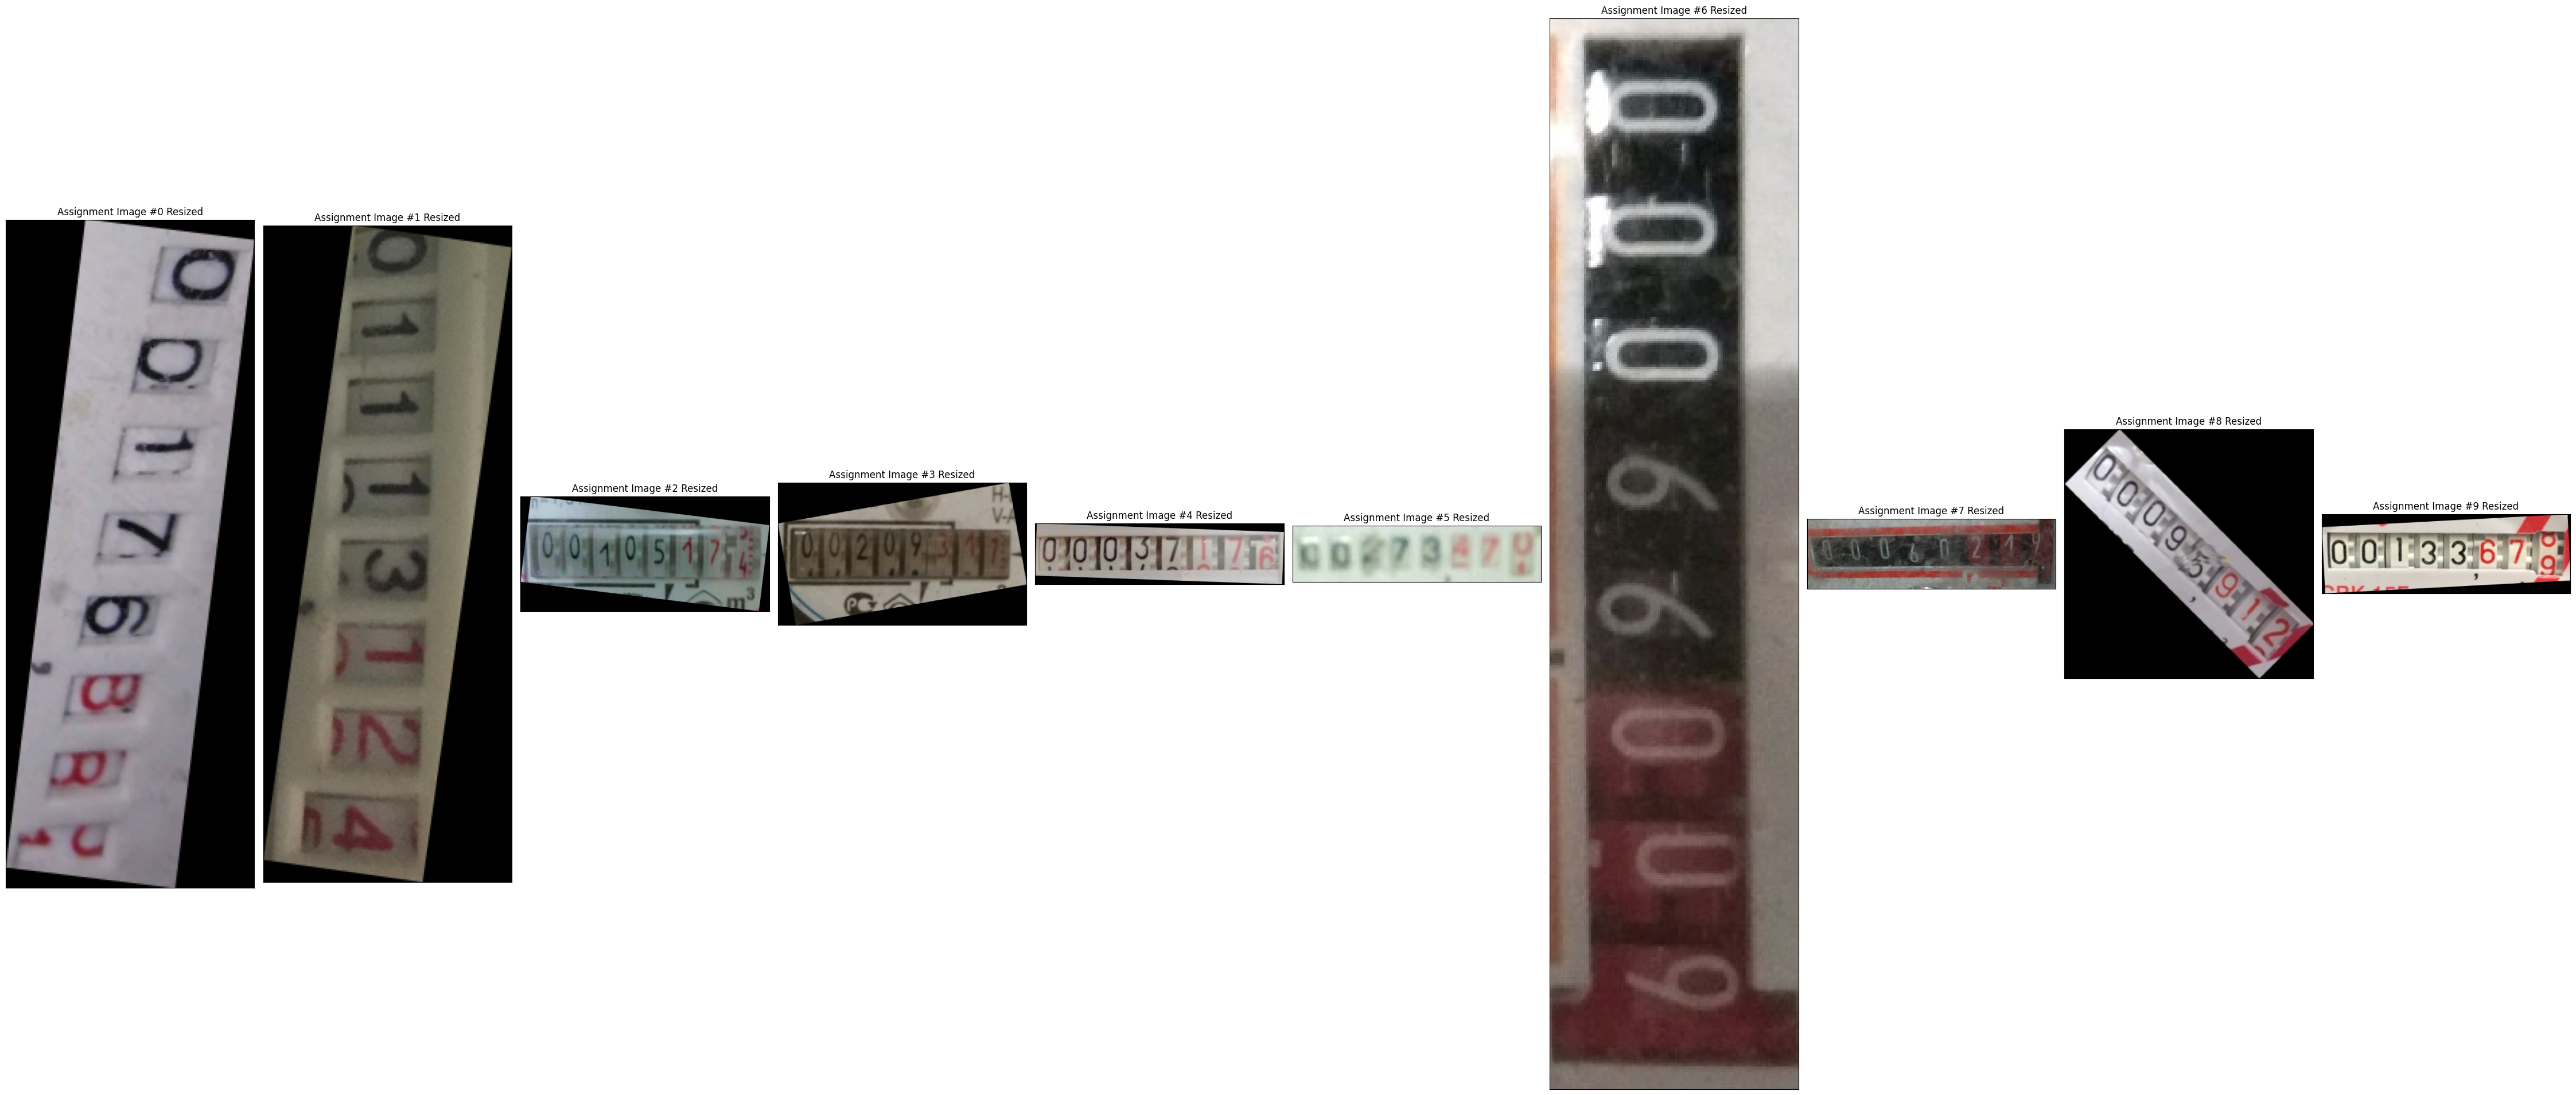

In [33]:
from glob import glob
img_fns = glob(r'WaterMeters\images\*')
plot_corp_imgs(img_fns, "Assignment")

1/1 [==============================] - 1s 1s/step


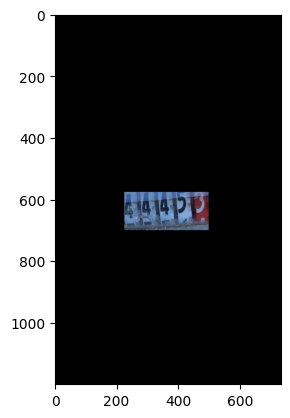

In [25]:
segmented_img = segment_input_img(r'./assignment_image/42967_SAFP064689.jpeg')
# segmented_img = segment_input_img(r'./assignment_image/43850_SAFN138267.jpeg')
# segmented_img = segment_input_img(r'./assignment_image/43060_SATM091088.jpeg')
# segmented_img = segment_input_img(r'./assignment_image/43216_SAFP039486.jpeg')
# segmented_img = segment_input_img(r'D:\Anuj\Study\project\utility meeter reading\WaterMeters\images\id_1131_value_40_506.jpg')

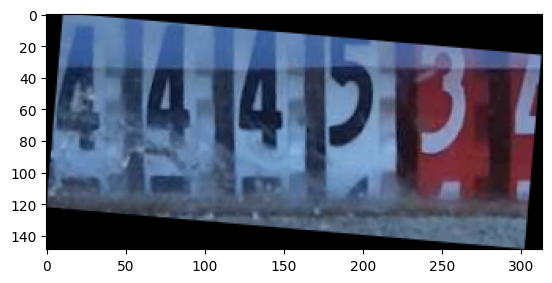

In [91]:
plt.imshow(segmented_img)
# (segmented_img, 'Test Images')